In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Visualización.
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. Dataset

El conjunto de datos CIRCLES consiste en puntos en un plano que forman dos círculos, de aquí el nombre de "circles". Cada círculo corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hace un gràfico para visualizar los dos círculos (con colores diferentes para cada grupo). 

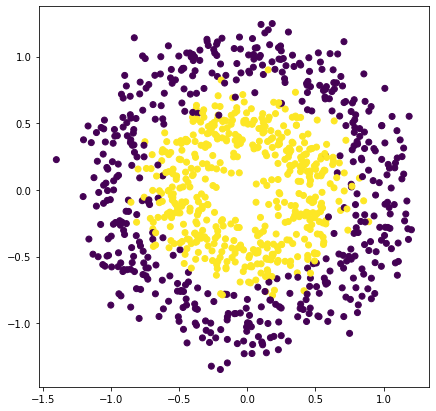

In [2]:
df = datasets.make_circles(n_samples=1000, factor=.5, noise=.15, random_state=42)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group, label = "sa")

Antes de aplicar ningún modelo, tenemos que separar los datos entre el conjunto de *train* y de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*.

In [3]:
random_state = 24

X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], random_state=random_state, test_size = 0.2)

A lo largo del ejercicio aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una _meshgrid_ con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde. También veremos las areas de indecisión, casos en los que el modelo no se inclina ni hacia una clase ni hacia otra (o si que se inclina pero no lo tiene 100% claro), estas seran blanquinosas.

In [4]:
# Vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1 

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Dibujamos las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.2. KNN

El objetivo de este ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

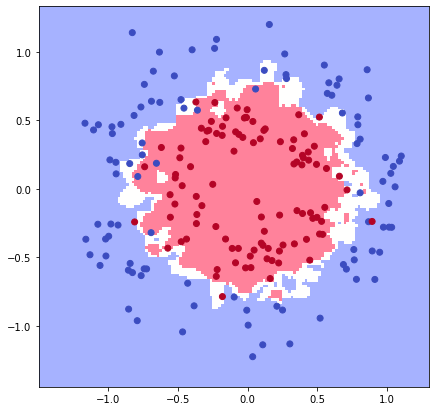

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

n_neighbors = 2

knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_model.fit(X_train, y_train)

plot_decision_boundaries(X_test[:, 0], X_test[:, 1], y_test, knn_model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.

In [9]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()

k_range = list(range(1, 11))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy', verbose=1)

grid_search=grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [10]:
grid_search.best_params_

{'n_neighbors': 7}

In [14]:
result = []
for i in range(0, 10):
    print('n_neighbors {}: mean = {}  ({}, {})'.format(
                        i + 1,
                        round(grid_search.cv_results_['mean_test_score'][i], 4), 
                        round(grid_search.cv_results_['mean_test_score'][i] - grid_search.cv_results_['std_test_score'][i], 4),
                        round(grid_search.cv_results_['mean_test_score'][i] + grid_search.cv_results_['std_test_score'][i], 4)))
    mean = grid_search.cv_results_['mean_test_score'][i]
    st = grid_search.cv_results_['std_test_score'][i]
    result.append([mean - st, mean, mean + st])

n_neighbors 1: mean = 0.9062  (0.9021, 0.9104)
n_neighbors 2: mean = 0.9013  (0.8916, 0.9109)
n_neighbors 3: mean = 0.9225  (0.9057, 0.9393)
n_neighbors 4: mean = 0.9225  (0.9077, 0.9373)
n_neighbors 5: mean = 0.9312  (0.9142, 0.9483)
n_neighbors 6: mean = 0.9325  (0.9123, 0.9527)
n_neighbors 7: mean = 0.935  (0.9233, 0.9467)
n_neighbors 8: mean = 0.935  (0.9223, 0.9477)
n_neighbors 9: mean = 0.9338  (0.9213, 0.9462)
n_neighbors 10: mean = 0.9325  (0.9157, 0.9493)


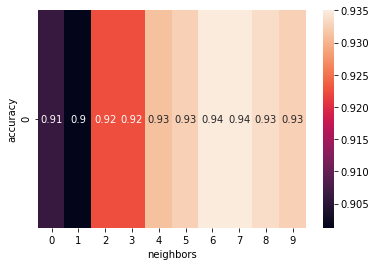

In [15]:
sns.heatmap([grid_search.cv_results_['mean_test_score']], annot=True)
plt.ylabel('accuracy')
plt.xlabel('neighbors')
plt.show()

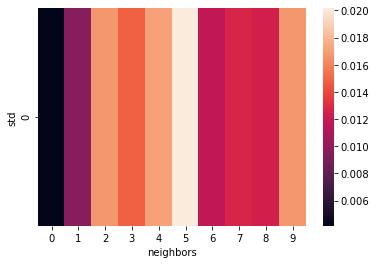

In [16]:
sns.heatmap([grid_search.cv_results_['std_test_score']])
plt.ylabel('std')
plt.xlabel('neighbors')
plt.show()

En el primer mapa de calor se observan los promedios de las precisiones cuando n_neighbors toma los valores del 1 al 10. Los mejores resultados se obtuvieron con valores de 7 y 8 con 0.94 para ambos casos. Sin embargo, para el 2do mapa de calor se visualiza las desviaciones estándares de los promedios anteriores. El mejor n_neighbors es 7, debido al resultado inferior de la desviación estándar en relación al 8.

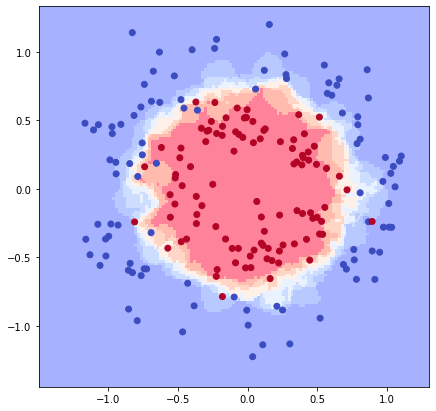

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

plot_decision_boundaries(X_test[:, 0], X_test[:, 1], y_test, knn_model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02)

In [18]:
y_pred = knn_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[92,  7],
       [ 3, 98]], dtype=int64)

In [19]:
accuracy= accuracy_score(y_test,y_pred)
accuracy

0.95

In [ ]:
En el primer mapa de calor se observan los promedios de las precisiones cuando n_neighbors toma los valores del 1 al 10. Los mejores resultados se obtuvieron con valores de 7 y 8 con 0.94 para ambos casos. Sin embargo, para el 2do mapa de calor se visualiza las desviaciones estándares de los promedios anteriores. El mejor n_neighbors es 7, debido al resultado inferior de la desviación estándar en relación al 8.